In [1]:
import sys
print(sys.version)

import warnings
warnings.filterwarnings('ignore')

3.5.2 (default, Nov 23 2017, 16:37:01) 
[GCC 5.4.0 20160609]


In [2]:
import torch
from torch.utils import data
import torch.nn as nn

In [3]:
cifar_10_folder = './datasets/cifar-10/'
cifar_100_folder = './datasets/cifar-100/'
flower_17_folder = './datasets/flowers-17/'
flower_102_folder = './datasets/flowers-102/'
mnist_folder = './datasets/mnist/'

In [4]:
import dataloaders.Cifar10Dataset as cd10
import dataloaders.Cifar100Dataset as cd100
import dataloaders.Flowers17Dataset as fl17
import dataloaders.Flowers102Dataset as fl102
import dataloaders.MnistDataset as mn

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
#cudnn.benchmark = True

# Parameters
params = {'batch_size': 32,
          'shuffle': True,
          'num_workers': 2}
max_epochs = 100


# Generators
training_set = mn.MnistDataset(mnist_folder, dataset_type='train')
#training_set.setRotation(True)
#training_set.setCrop(True)
#training_set.setFlip(True)
#training_set.setBlur(True)
#training_set.setNoise(True)
#training_set.setNormalization(True, 0.5, 0.2)
training_generator = data.DataLoader(training_set, **params)

validation_set = mn.MnistDataset(mnist_folder, dataset_type='val')
#validation_set.setNormalization(True, 0.5, 0.2)
validation_generator = data.DataLoader(validation_set, **params)

test_set = mn.MnistDataset(mnist_folder, dataset_type='test')
#test_set.setNormalization(True, 0.5, 0.2)
test_generator = data.DataLoader(test_set, **params)

In [5]:
import models.CifarModel as cm
import models.FlowerModel as fm
import models.MnistFcModel as mm
    
#model = cm.CifarModel('cifar_100',100)
#model = fm.FlowerModel('flower_102',102)
model = mm.MnistFcModel('mnist_fc',10)
model.float()
model.to(device)

print(model)

MnistFcModel(
  (fc1): Linear(in_features=784, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=10, bias=True)
)


In [6]:
#model(torch.randn(1,3,100,100).to(device)).shape
model(torch.randn(1,1,1,28*28).to(device)).shape
#model(torch.randn(1,3,32,32).to(device)).shape

torch.Size([1, 1, 1, 10])

In [7]:
print(training_set.__len__(), training_set.dataset_type)
print(validation_set.__len__(), validation_set.dataset_type)
print(test_set.__len__(), test_set.dataset_type)

#for local_X, local_y in training_generator:
#
#     training_set.plotImage(local_X[0,:,:,:], local_y[0])
#     break
#     #    pass

60000 train
10000 val
10000 test


In [8]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.00001)

Epoch 1/10
 Training ... 
 progres: 0.27, loss: 0.071548, acc: 0.23
 progres: 0.53, loss: 0.071086, acc: 0.27
 progres: 0.80, loss: 0.070525, acc: 0.36
 Validating ... 
 loss: 0.067183, acc: 0.71
 Saving best model!
Epoch 2/10
 Training ... 
 progres: 0.27, loss: 0.066042, acc: 0.72
 progres: 0.53, loss: 0.064859, acc: 0.74
 progres: 0.80, loss: 0.063720, acc: 0.75
 Validating ... 


No handles with labels found to put in legend.


 loss: 0.059372, acc: 0.82
 Saving best model!


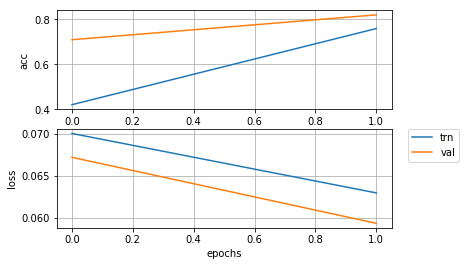

Epoch 3/10
 Training ... 
 progres: 0.27, loss: 0.058639, acc: 0.82
 progres: 0.53, loss: 0.058098, acc: 0.82
 progres: 0.80, loss: 0.057624, acc: 0.82
 Validating ... 
 loss: 0.055770, acc: 0.85
 Saving best model!
Epoch 4/10
 Training ... 
 progres: 0.27, loss: 0.055469, acc: 0.84
 progres: 0.53, loss: 0.055141, acc: 0.85
 progres: 0.80, loss: 0.054872, acc: 0.85
 Validating ... 
 loss: 0.053753, acc: 0.87
 Saving best model!
Epoch 5/10
 Training ... 
 progres: 0.27, loss: 0.053513, acc: 0.86
 progres: 0.53, loss: 0.053322, acc: 0.87
 progres: 0.80, loss: 0.053143, acc: 0.87
 Validating ... 
 loss: 0.052358, acc: 0.88
 Saving best model!
Epoch 6/10
 Training ... 
 progres: 0.27, loss: 0.052236, acc: 0.88
 progres: 0.53, loss: 0.052058, acc: 0.88
 progres: 0.80, loss: 0.051943, acc: 0.88
 Validating ... 
 loss: 0.051417, acc: 0.89
 Saving best model!
Epoch 7/10
 Training ... 
 progres: 0.27, loss: 0.051260, acc: 0.89
 progres: 0.53, loss: 0.051178, acc: 0.89
 progres: 0.80, loss: 0.05

No handles with labels found to put in legend.


 loss: 0.050792, acc: 0.89
 Saving best model!


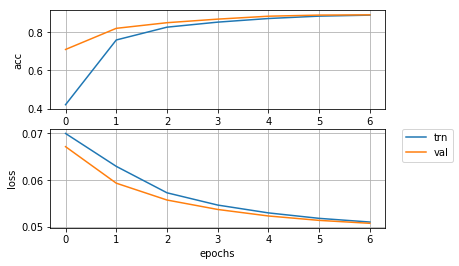

Epoch 8/10
 Training ... 
 progres: 0.27, loss: 0.050614, acc: 0.89
 progres: 0.53, loss: 0.050604, acc: 0.89
 progres: 0.80, loss: 0.050545, acc: 0.89
 Validating ... 
 loss: 0.050356, acc: 0.89
 Saving best model!
Epoch 9/10
 Training ... 
 progres: 0.27, loss: 0.050242, acc: 0.88
 progres: 0.53, loss: 0.050204, acc: 0.88
 progres: 0.80, loss: 0.050152, acc: 0.88
 Validating ... 
 loss: 0.050031, acc: 0.89
 Saving best model!
Epoch 10/10
 Training ... 
 progres: 0.27, loss: 0.049861, acc: 0.88
 progres: 0.53, loss: 0.049840, acc: 0.88
 progres: 0.80, loss: 0.049826, acc: 0.88
 Validating ... 
 loss: 0.049785, acc: 0.87
 Saving best model!


In [9]:
import matplotlib.pyplot as plt

def trainModel(model, train_dataset_gen, val_dataset_gen, criterion, optimizer, num_of_epochs, device):
    
    train_acc = []
    train_loss = []
    val_acc = []
    val_loss = []
    epochs = []
    
    model = model.to(device)
    best_val_loss = sys.float_info.max
    
    
    for epoch in range(num_of_epochs):
        print("Epoch {}/{}".format(epoch+1, num_of_epochs))
        
        for phase in ['train', 'validate']:
            
            cumulated_loss = 0.0
            cumulated_inputs_count = 0
            cumulated_acc = 0.0
            
            if phase == 'train':
                model.train()
                print(" Training ... ")
                
                for i, (inputs, labels) in enumerate(train_dataset_gen,0):
                    inputs, labels = inputs.to(device), labels.to(device)
                
                    optimizer.zero_grad()
                    
                    with torch.set_grad_enabled(True):
            
                        outputs = model(inputs)
                        _, preds = torch.max(outputs,1)
                        loss = criterion(outputs, labels)
                        
                        
                        loss.backward()
                        optimizer.step()
                        
                        cumulated_loss += loss.item()
                        cumulated_inputs_count += inputs.shape[0]
                        cumulated_acc += sum((preds.cpu().numpy() == labels.cpu().numpy()) == True)
                        
                        if((i+1) % 500 == 0):
                            print(' progres: {:.2f}, loss: {:.6f}, acc: {:.2f}'.format(cumulated_inputs_count/training_set.length(), cumulated_loss/cumulated_inputs_count, cumulated_acc/cumulated_inputs_count))
                        
                
                train_acc.append(cumulated_acc/cumulated_inputs_count)
                train_loss.append(cumulated_loss/cumulated_inputs_count)
                        
            else:
                model.eval()
                print(" Validating ... ")
                
                for i, (inputs, labels) in enumerate(validation_generator,0):
                    inputs, labels = inputs.to(device), labels.to(device)
                
                    with torch.set_grad_enabled(False):
            
                        outputs = model(inputs)
                        _, preds = torch.max(outputs,1)
                        loss = criterion(outputs, labels)
                        
                        cumulated_loss += loss.item()
                        cumulated_inputs_count += inputs.shape[0]
                        cumulated_acc += sum((preds.cpu().numpy() == labels.cpu().numpy()) == True)
                        
                val_acc.append(cumulated_acc/cumulated_inputs_count)
                val_loss.append(cumulated_loss/cumulated_inputs_count)
                epochs.append(epoch)
                        
                print(' loss: {:.6f}, acc: {:.2f}'.format(val_loss[-1], val_acc[-1]))
                model.save_model({
                    'epoch': epoch + 1,
                    'state_dict': model.state_dict(),
                }, False)
                
                if(best_val_loss > cumulated_loss/cumulated_inputs_count):
                    best_val_loss = cumulated_loss/cumulated_inputs_count
                    print(' Saving best model!')
                    model.save_model({
                        'epoch': epoch + 1,
                        'state_dict': model.state_dict(),
                    }, True)
                    
        if(epoch % 5 == 1):
            
            fig, axs = plt.subplots(2, 1)
            axs[0].plot(epochs, train_acc, label='trn')
            axs[0].plot(epochs, val_acc, label='val')
            axs[0].grid(True)
            axs[0].set_xlabel('epochs')
            axs[0].set_ylabel('acc')
            plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
            
            axs[1].plot(epochs, train_loss, label='trn')
            axs[1].plot(epochs, val_loss, label='val')
            axs[1].grid(True)
            axs[1].set_xlabel('epochs')
            axs[1].set_ylabel('loss')
            plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
            
            plt.show()

trainModel(model, training_generator, validation_generator, criterion, optimizer, 10,device)

In [13]:
import numpy as np

#model = fm.FlowerModel('flower_102',102)
model = mm.MnistFcModel('mnist_fc',10)
model.float()
model.load_model(load_best=True)
model.to(device)

print(" Testing ... ")
cumulated_loss = 0.0
cumulated_inputs_count = 0
cumulated_acc = 0.0
conf_matrix = np.zeros((10,10))

for i, (inputs, labels) in enumerate(test_generator,0):
    inputs, labels = inputs.to(device), labels.to(device)

    with torch.set_grad_enabled(False):

        outputs = model(inputs)
        _, preds = torch.max(outputs,1)
        loss = criterion(outputs, labels)
        for label, pred in zip(labels, preds):
            conf_matrix[pred.item(), label.item()] += 1

        cumulated_loss += loss.item()
        cumulated_inputs_count += inputs.shape[0]
        cumulated_acc += sum((preds.cpu().numpy() == labels.cpu().numpy()) == True)

        
print(' loss: {:.6f}, acc: {:.2f}'.format(cumulated_loss/cumulated_inputs_count, cumulated_acc/cumulated_inputs_count))
                  

 Testing ... 
 loss: 0.049783, acc: 0.87


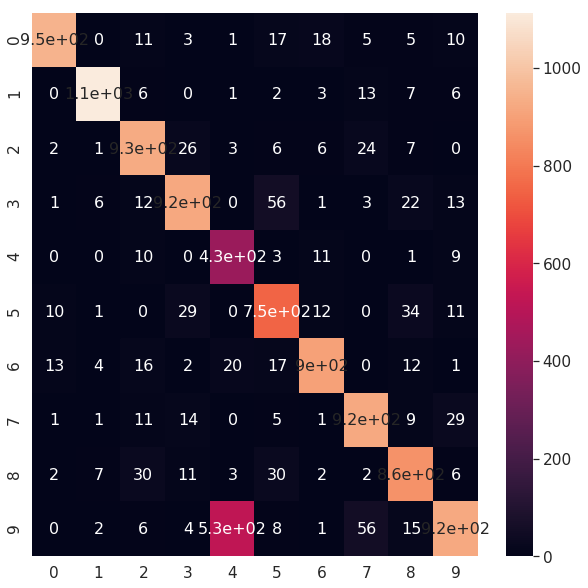

In [16]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plotConfusionMatrix(matrix):
    
    fig, ax = plt.subplots()
    fig.set_size_inches(10,10)
    df_cm = pd.DataFrame(matrix, range(matrix.shape[0]),
                  range(matrix.shape[1]))
    sn.set(font_scale=1.4)#for label size
    sn.heatmap(df_cm, annot=True,annot_kws={"size": 16})# font size
    
plotConfusionMatrix(conf_matrix[:,:])

In [5]:
print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)

(60000, 784) (60000,)
(10000, 784) (10000,)


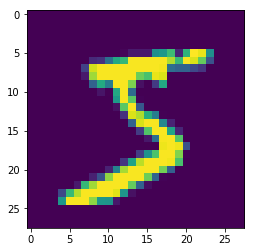

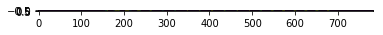

5


In [17]:
import matplotlib.pyplot as plt
index = 0

plt.imshow(train_x[index,:].reshape(28,28))
plt.show()

plt.imshow(train_x[index,:].reshape(1, 28*28))
plt.show()

print(train_y[index])

